<div style="text-align:center"><span style="color:black; font-family:Times New Roman; font-size:3em;"> Russian housing market prediction </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> The goal of this project is to predict the sale price of  Russian houses based on a broad spectrum of features provided by Kaggle (https://www.kaggle.com/c/sberbank-russian-housing-market/data). The training data is given from August 2011 to June 2015 and the test data will be predicted from July 2015 to May 2016. The feature information describes (almost) every aspect of residential homes as well as overall conditions in Russia's economy and finance sector. 
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
One of the challenges in this dataset is to clean data and feature engineering because the data exhibits a lot of missing values and several feature variables highly correlated to each other. Through this project, I will show comprehensive data exploration, including: univariate and bi-variate analysis, multicollinearity treatment, missing values treatment in order to maximize insight into data  and improve the quality of the input variables.
After preprocessing data, a highly sophisticated algorithm -  XGBoost regression is used to train and predict house price with satisfying performance.  


 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data exploration  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   Below are the steps involved to understand, clean and prepare my data for building a XGBoost model: 
<br \>
1.  Output variable analysis 
<br \>
2.	Multicollinearity treatment
<br \>
3.	Mislabel treatment
<br \>
4.	Missing values treatment
<br \>
5.  Create new features
<br \>
6.  Log transformations for skewed features
<br \>
7.  Correlation heatmap of output variable
<br \>
8.  Outlier treatment 

 </span></div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
np.set_printoptions(precision=5)

import xgboost as xgb
from xgboost import DMatrix, cv, train, plot_importance 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import ParameterGrid

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   The data is extracted from train.csv, test.csv and macro.csv. The train.csv and test.csv are the training and test dataset which contain information about individual property. The macro.csv provides data on Russia's macro economy and financial sector, which is joined to the train and test sets on the "timestamp" (transaction date) column. After combining with Macro data, there are 391 variables.   

 </span></div>

In [181]:
df_train=pd.read_csv('train.csv/train.csv', parse_dates=['timestamp'])
df_test=pd.read_csv('test.csv/test.csv', parse_dates=['timestamp'])
df_macro=pd.read_csv('macro.csv/macro.csv', parse_dates=['timestamp'])
train_macro = pd.merge(df_train, df_macro, how='left', on='timestamp')
test_macro = pd.merge(df_test, df_macro, how='left', on='timestamp') 
print 'The sample number and feature number of the train_macro set : {}'.format(train_macro.shape)
print 'The sample number and feature number of the test_macro set : {}'.format(test_macro.shape)

The sample number and feature number of the train_macro set : (30471, 391)
The sample number and feature number of the test_macro set : (7662, 390)


<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Output variable analysis </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   The target variable is price_doc (sale price of a property). Since price_doc exhibits skewed distributions, the log transformation can be applied on price_doc to decrease the data variability and make data more closely to the normal distribution.


 </span></div>

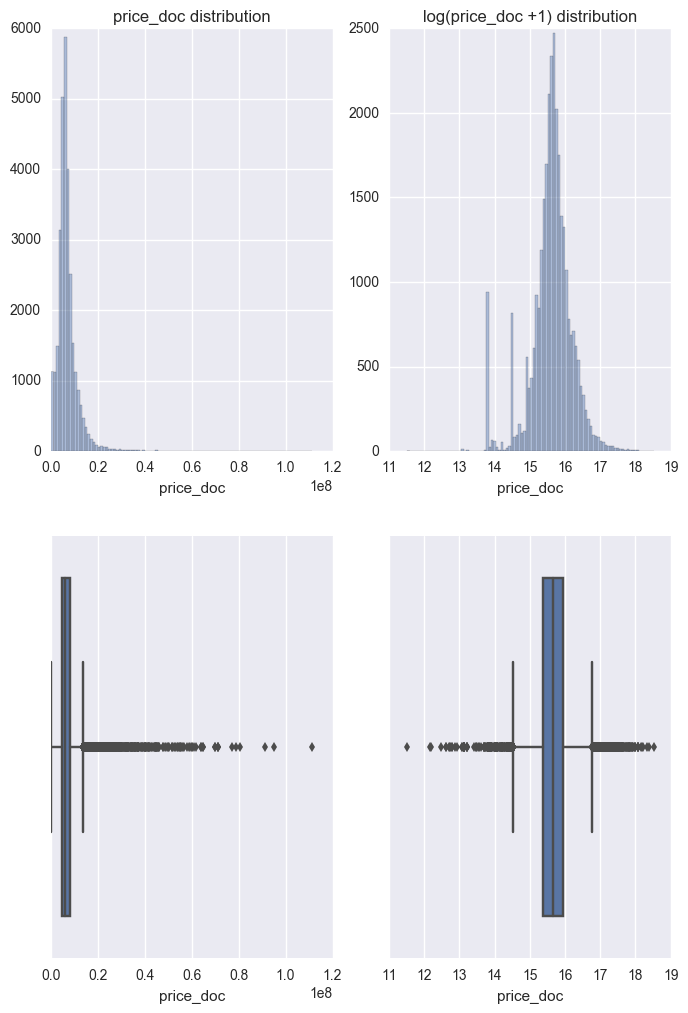

In [6]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(8,12))

F=sns.distplot(train_macro['price_doc'], kde=False, bins=100, ax=ax[0,0])
F.set(title='price_doc distribution')

F1=sns.distplot(np.log1p(train_macro['price_doc']), kde=False, bins=100,ax=ax[0,1])
F1.set(title='log(price_doc +1) distribution')

G=sns.boxplot(x=train_macro['price_doc'],ax=ax[1,0])
#F1.set(xlim=(0,2))
G1=sns.boxplot(x=np.log1p(train_macro['price_doc']),ax=ax[1,1])

In [182]:
train_macro['price_doc']=np.log1p(train_macro['price_doc'].values) 

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Multicollinearity treatment </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   Multicollinearity happens when two or more of the features in a regression model are highly correlated to each other. It results the standard errors of the partial regression coefficients may be too high so that the coefficients cannot be estimated precisely. My strategy for dealing with multicollinearity is to remove highly correlated features (correlation coefficients > 0.99 ) from the model because they supply redundant information. However, I keep the ones with higher correlation to the output variable. For example, sadovoe_km (Distance to the Garden Ring) are highly correlated to bulvar_ring_km (distance to the Boulevard Ring), kremlin_km (Distance to the city center) and ttk_km (Distance to the Third Transport Ring). Since sadovoe_km show higher correlation with price_doc, sadovoe_km is kept for data modeling and the other three are removed. In total, I remove 89 features that are highly correlated to each other.    

 </span></div>

In [144]:
df_corr = train_macro.drop(["timestamp"], axis=1).corr(method='pearson', min_periods=100)
df_corr = np.abs(df_corr)
price_corr=df_corr['price_doc'].sort_values(ascending=False)[1:]
price_corr_list=price_corr.index
   
drop_list=set([])
threshold=0.99
for f in price_corr_list:
    A=df_corr[f].sort_values(ascending=False)
    if f not in drop_list:
        for i in A[A.values > threshold].index:
            if i not in drop_list and i!=f:
                    print '{} | {} | R2={}'.format(f, i, A[i])
                    drop_features=[i]
                    drop_list=drop_list|set(drop_features)

sadovoe_km | bulvar_ring_km | R2=0.998443409677
sadovoe_km | kremlin_km | R2=0.99745551871
sadovoe_km | ttk_km | R2=0.992477130705
metro_min_walk | metro_km_walk | R2=1.0
cafe_count_5000_price_1000 | cafe_count_5000 | R2=0.997248543659
cafe_count_5000_price_1000 | cafe_count_5000_price_500 | R2=0.996720004724
cafe_count_5000_price_1000 | cafe_count_5000_price_1500 | R2=0.995779665994
cafe_count_5000_price_1000 | office_count_5000 | R2=0.990975634974
school_km | preschool_km | R2=0.99943058121
ekder_male | ekder_all | R2=0.992600630349
cafe_count_5000_price_2500 | cafe_count_5000_price_4000 | R2=0.990438429491
public_transport_station_km | public_transport_station_min_walk | R2=1.0
gdp_deflator | provision_retail_space_sqm | R2=1.0
gdp_deflator | theaters_viewers_per_1000_cap | R2=0.999992893935
gdp_deflator | gdp_annual | R2=0.994969652301
turnover_catering_per_cap | construction_value | R2=0.992024162767
salary | grp | R2=0.999979701259
salary | museum_visitis_per_100_cap | R2=0.99972

In [145]:
print 'The number of featurs that are very highly correlated: {}'.format(len(drop_list))
sorted(list(drop_list))

The number of featurs that are very highly correlated: 89


['0_13_all',
 '0_13_female',
 '0_13_male',
 '0_17_all',
 '0_17_female',
 '0_6_all',
 '0_6_female',
 '0_6_male',
 '16_29_all',
 '16_29_female',
 '16_29_male',
 '7_14_all',
 '7_14_male',
 'baths_share',
 'big_church_count_1500',
 'brent',
 'bulvar_ring_km',
 'cafe_avg_price_1000',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_avg_price_3000',
 'cafe_avg_price_500',
 'cafe_avg_price_5000',
 'cafe_count_1000',
 'cafe_count_1000_price_500',
 'cafe_count_1500',
 'cafe_count_1500_price_1500',
 'cafe_count_2000',
 'cafe_count_2000_price_1000',
 'cafe_count_2000_price_2500',
 'cafe_count_2000_price_500',
 'cafe_count_3000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_500',
 'cafe_count_5000',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_4000',
 'cafe_count_5000_price_500',
 'cafe_sum_3000_max_price_avg',
 'cafe_sum_5000_min_price_avg',
 'children_preschool',
 'children_school',
 'church_count_1500',
 'construction_value',
 'ekder_all'

In [183]:
train_macro.drop(drop_list,axis=1, inplace=True)
test_macro.drop(drop_list,axis=1, inplace=True)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Mislabel treatment </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   The categories of the state variable should be 1, 2, 3, 4. However, there is one data labeled as 33. I treat it as mislabel data and I delete this data.   

 </span></div>

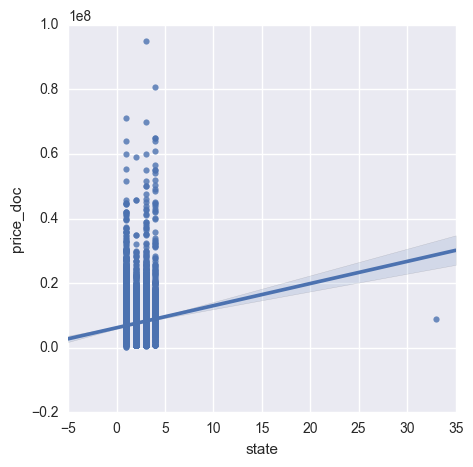

In [18]:
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
sns.regplot(x=train_macro['state'],y=train_macro['price_doc'])

In [184]:
train_macro.drop(train_macro['state'][train_macro['state'].values ==33.0].index,axis=0, inplace=True)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Missing values treatment 
 </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The train data and the test data are combined as train_test_macro for missing value imputation. There are 80 features with missing values. I directly delete one feature (provision_retail_space_modern_sqm) with 98 % missing values. 
For the rest of features, imputation using prediction model is applied to fill in the missing values with estimated ones.
I use a linear regression model to estimate values that will substitute the missing data. I divide the train_test_macro dataset into two sets: one with no missing values for the variable and the other one with missing values. The first data set is used for training the regression model and predicting values on the second data set. For each variable with missing values, at most five features with no missing values and high correlation to that variable are chosen to train the model. For some features with unique numbers less than 20, I use K Neighbors Classifier to impute the missing values.  


 </span></div>

In [185]:
train_macro.drop(['id'],axis=1, inplace=True)
test_macro.drop(['id'],axis=1, inplace=True)
train_test_macro=pd.concat([train_macro, test_macro], axis=0, ignore_index=True)
train_test_macro=train_test_macro1.copy()
train_test_macro.drop(['price_doc'], axis=1, inplace=True)
print train_test_macro.shape

(38132, 300)


In [186]:
missing=(train_test_macro.isnull().sum()/train_test_macro.isnull().count()).sort_values(ascending=False)
missing=missing[missing.values > 0]
print 'The number of features that have missing values: {}'.format(len(missing))
print missing

The number of features that have missing values: 80
provision_retail_space_modern_sqm      0.980253
hospital_beds_raion                    0.468347
cafe_sum_500_max_price_avg             0.431134
cafe_sum_500_min_price_avg             0.431134
build_year                             0.384297
state                                  0.373781
invest_fixed_assets_phys               0.285875
divorce_rate                           0.285875
power_clinics                          0.285875
pop_migration                          0.285875
perinatal_mort_per_1000_cap            0.285875
overdue_wages_per_cap                  0.285875
apartment_build                        0.285875
child_on_acc_pre_school                0.285875
lodging_sqm_per_cap                    0.285875
housing_fund_sqm                       0.285875
infant_mortarity_per_1000_cap          0.285875
hot_water_share                        0.285875
sewerage_share                         0.285875
share_own_revenues                  

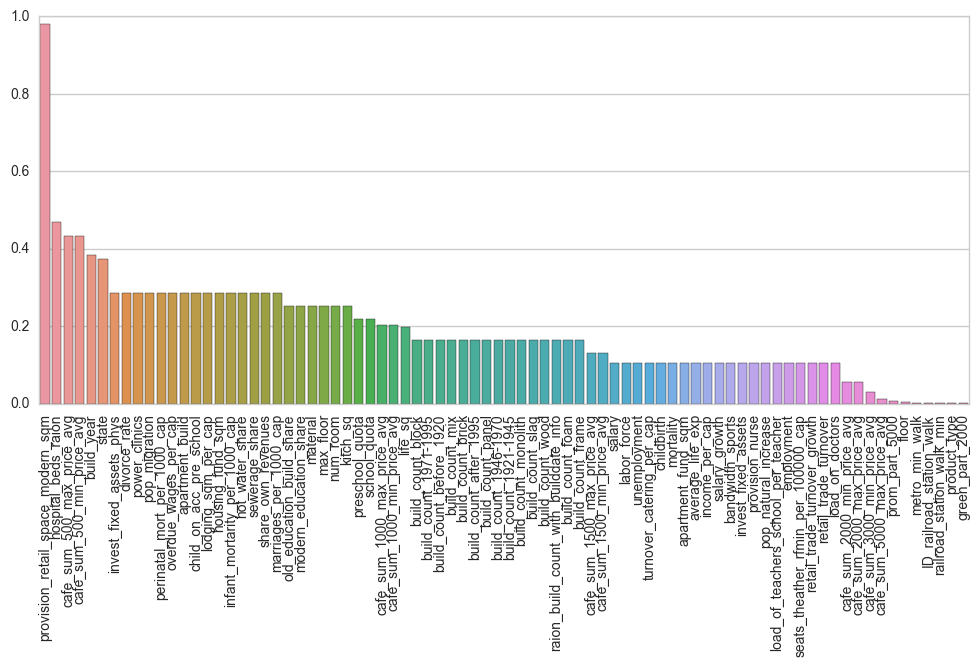

In [191]:
#plot the missing value count
f, ax = plt.subplots(figsize=(12,5))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = missing.index, y = missing.values)
plt.xticks(rotation = 90)
sns.plt.show()

In [150]:
train_test_macro.drop(['provision_retail_space_modern_sqm'],axis=1, inplace=True)

In [151]:
def features_list_for_imputation(df,nunique):    
    df_corr = df.drop(["timestamp"], axis=1).corr(method='pearson', min_periods=100)
    df_corr = np.abs(df_corr)
    missing=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=True)
    missing=missing[missing.values > 0]
    print 'The number of features that have missing values: {}'.format(len(missing))
    object_list=[f for f in missing.index if df[f].dtypes=='object']
    
    thresh=0.3
    missing_imputed_list=[]
    for f in missing.index:
        if f in object_list:
            continue
        if df[f].nunique() > nunique:
            corr_onefeature=df_corr[f].sort_values(ascending=False)[1:]
            index_list=[x for x in corr_onefeature[corr_onefeature.values >= thresh].index if x not in missing.index]
            corr_onefeature=corr_onefeature[index_list]
            if len(corr_onefeature)>1:
                print '###########'
                print f
                print corr_onefeature[:5]
                missing_imputed_list.append(f) 
    print 'The number of missing_imputed_list  : {}'.format(len(missing_imputed_list))
    return df_corr, missing, missing_imputed_list

In [152]:
def linear_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, featurenum , plot):
    thresh=0.3
    #featurenum=5
    #print missing_imputed_list[i]
    corr_onefeature=df_corr[missing_imputed_list[i]].sort_values(ascending=False)[1:]
    index_list=[x for x in corr_onefeature[corr_onefeature.values >= thresh].index if x not in missing.index]
    corr_onefeature=corr_onefeature[index_list]
    #print corr_onefeature[corr_onefeature.values>= thresh][:5]
    df=DataFrame(train_test_macro[corr_onefeature[corr_onefeature.values>= thresh].index[:featurenum]])
    df[missing_imputed_list[i]]=train_test_macro[missing_imputed_list[i]].values
    X_notnan=df.ix[df[missing_imputed_list[i]].notnull(),0:-1 ]
    X_isnan=df.ix[df[missing_imputed_list[i]].isnull(),0:-1]
    Y_notnan=df.ix[df[missing_imputed_list[i]].notnull(),-1]
    
    from sklearn.linear_model import LinearRegression
    #from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import accuracy_score
    lr=LinearRegression()
    lr.fit(X_notnan,Y_notnan)
   
    y_pred_isnan=lr.predict(X_isnan)
    y_pred_notnan=lr.predict(X_notnan)
    
    y_pred_isnan=np.where(y_pred_isnan>0, y_pred_isnan, np.nan)
    #y_pred_isnan=np.where(y_pred_isnan>Y_notnan.max(), Y_notnan.max(), y_pred_isnan)
   
    y_pred_isnan=(y_pred_isnan).astype(int)
    
    if plot ==1:
        print missing_imputed_list[i]
        print corr_onefeature[corr_onefeature.values>= thresh][:5]
        print Y_notnan.unique()    
        print y_pred_isnan
        #print missing[missing_imputed_list[i]]*100
        #print 'MSE scores: {}'.format(mean_squared_error(y_pred_notnan,Y_notnan))
        fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
        ax1.scatter(X_notnan.ix[:,0],Y_notnan,label='Not NaN data', color='yellow',s=10 )
        ax1.scatter(X_isnan.ix[:,0], y_pred_isnan,label='Imputed NaN data', color='blue',marker='o',s=20)
        ax1.set_xlabel(df.columns[0])
        ax1.set_ylabel(df.columns[-1])
        ax1.legend(loc='upper left')

        ax2.scatter(X_notnan.ix[:,1],Y_notnan,label='Not NaN data', color='yellow',s=10 )
        ax2.scatter(X_isnan.ix[:,1], y_pred_isnan,label='Imputed NaN data', color='blue',marker='o',s=20)
        ax2.set_xlabel(df.columns[1])
        ax2.set_ylabel(df.columns[-1])
        ax2.legend(loc='upper left')
    
    nanvalue=train_test_macro[missing_imputed_list[i]][train_test_macro[missing_imputed_list[i]].isnull()]
    train_test_macro_new=train_test_macro.copy()
    train_test_macro_new[missing_imputed_list[i]][nanvalue.index]=y_pred_isnan
    return train_test_macro_new

In [153]:
def KNN_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, featurenum , plot,n_neighbors):
    thresh=0.3
    #featurenum=5
    #print missing_imputed_list[i]
    corr_onefeature=df_corr[missing_imputed_list[i]].sort_values(ascending=False)[1:]
    index_list=[x for x in corr_onefeature[corr_onefeature.values >= thresh].index if x not in missing.index]
    corr_onefeature=corr_onefeature[index_list]
    #print corr_onefeature[corr_onefeature.values>= thresh][:5]
    df=DataFrame(train_test_macro[corr_onefeature[corr_onefeature.values>= thresh].index[:featurenum]])
    df[missing_imputed_list[i]]=train_test_macro[missing_imputed_list[i]].values
    X_notnan=df.ix[df[missing_imputed_list[i]].notnull(),0:-1 ]
    X_isnan=df.ix[df[missing_imputed_list[i]].isnull(),0:-1]
    Y_notnan=df.ix[df[missing_imputed_list[i]].notnull(),-1]
    
    
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import LabelEncoder
    encoder=LabelEncoder()
    Y_notnan=encoder.fit_transform(Y_notnan.values)
    
    lr=KNeighborsClassifier(n_neighbors=n_neighbors) 
    lr.fit(X_notnan,Y_notnan)
   
    y_pred_isnan=lr.predict(X_isnan)
    y_pred_notnan=lr.predict(X_notnan)
   
    if plot ==1:
        print missing_imputed_list[i]
        print corr_onefeature[corr_onefeature.values>= thresh][:5]
        print np.unique(Y_notnan)   
        print y_pred_isnan
        #print missing[missing_imputed_list[i]]*100
        print 'Accuracy: {}'.format(accuracy_score(y_pred_notnan,Y_notnan))
        fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
        ax1.scatter(X_notnan.ix[:,0],Y_notnan,label='Not NaN data', color='yellow',s=10 )
        ax1.scatter(X_isnan.ix[:,0], y_pred_isnan,label='Imputed NaN data', color='blue',marker='o',s=20)
        ax1.set_xlabel(df.columns[0])
        ax1.set_ylabel(df.columns[-1])
        ax1.legend(loc='upper left')

        ax2.scatter(X_notnan.ix[:,1],Y_notnan,label='Not NaN data', color='yellow',s=10 )
        ax2.scatter(X_isnan.ix[:,1], y_pred_isnan,label='Imputed NaN data', color='blue',marker='o',s=20)
        ax2.set_xlabel(df.columns[1])
        ax2.set_ylabel(df.columns[-1])
        ax2.legend(loc='upper left')
    y_pred_isnan=encoder.inverse_transform(y_pred_isnan)
    nanvalue_index=train_test_macro[missing_imputed_list[i]].isnull()
    train_test_macro_new=train_test_macro.copy()
    train_test_macro_new[missing_imputed_list[i]][nanvalue_index]=y_pred_isnan
    return train_test_macro_new

In [154]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro, 20)

The number of features that have missing values: 79
###########
green_part_2000
green_part_1500    0.942223
green_part_3000    0.908852
green_part_1000    0.735930
green_part_5000    0.729146
green_zone_part    0.705511
Name: green_part_2000, dtype: float64
###########
railroad_station_walk_min
railroad_station_avto_km     0.966131
railroad_km                  0.899915
railroad_station_avto_min    0.884318
detention_facility_km        0.581586
green_part_5000              0.549861
Name: railroad_station_walk_min, dtype: float64
###########
metro_min_walk
metro_km_avto                 0.986446
metro_min_avto                0.937427
radiation_km                  0.911000
power_transmission_line_km    0.900464
park_km                       0.894951
Name: metro_min_walk, dtype: float64
###########
ID_railroad_station_walk
ID_railroad_station_avto    0.659428
catering_km                 0.392378
swim_pool_km                0.389509
office_km                   0.376765
shopping_centers_km   

In [155]:
for i in range(len(missing_imputed_list)):
    train_test_macro=linear_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, 5 , 0)

In [156]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro, 20)    

The number of features that have missing values: 59
###########
cafe_sum_2000_max_price_avg
cafe_sum_3000_min_price_avg    0.541726
cafe_sum_5000_max_price_avg    0.490311
Name: cafe_sum_2000_max_price_avg, dtype: float64
###########
cafe_sum_2000_min_price_avg
cafe_sum_3000_min_price_avg    0.493827
cafe_sum_5000_max_price_avg    0.457513
Name: cafe_sum_2000_min_price_avg, dtype: float64
###########
cafe_sum_1500_max_price_avg
cafe_sum_5000_max_price_avg    0.313643
cafe_sum_3000_min_price_avg    0.308906
Name: cafe_sum_1500_max_price_avg, dtype: float64
###########
build_count_frame
raion_build_count_with_builddate_info    0.528301
build_count_slag                         0.435023
build_count_after_1995                   0.394610
Name: build_count_frame, dtype: float64
###########
build_count_1921-1945
build_count_slag                         0.857827
raion_build_count_with_builddate_info    0.857039
build_count_after_1995                   0.690707
build_count_monolith              

In [157]:
for i in range(len(missing_imputed_list)):
    train_test_macro=linear_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, 5,0)

In [158]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro, 20)

The number of features that have missing values: 49
###########
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg    0.981789
cafe_sum_2000_min_price_avg    0.655191
cafe_sum_2000_max_price_avg    0.635139
cafe_sum_500_min_price_avg     0.367497
cafe_sum_500_max_price_avg     0.367057
Name: cafe_sum_1500_min_price_avg, dtype: float64
###########
cafe_sum_1000_max_price_avg
cafe_sum_1500_max_price_avg    0.771598
cafe_sum_500_max_price_avg     0.511419
cafe_sum_500_min_price_avg     0.499736
cafe_sum_2000_max_price_avg    0.480074
cafe_sum_2000_min_price_avg    0.476325
Name: cafe_sum_1000_max_price_avg, dtype: float64
###########
cafe_sum_1000_min_price_avg
cafe_sum_1500_max_price_avg    0.762429
cafe_sum_2000_min_price_avg    0.480031
cafe_sum_500_min_price_avg     0.472213
cafe_sum_500_max_price_avg     0.471099
cafe_sum_2000_max_price_avg    0.464161
Name: cafe_sum_1000_min_price_avg, dtype: float64
The number of missing_imputed_list  : 3


In [159]:
for i in range(len(missing_imputed_list)):
    train_test_macro=linear_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, 5 , 0)

In [160]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro,2)

The number of features that have missing values: 46
###########
bandwidth_sports
gdp_annual_growth    0.964305
gdp_deflator         0.961353
fixed_basket         0.957610
deposits_value       0.941904
cpi                  0.939306
Name: bandwidth_sports, dtype: float64
###########
average_life_exp
gdp_annual_growth    0.919188
gdp_deflator         0.879961
deposits_value       0.873487
micex_cbi_tr         0.826763
fixed_basket         0.822694
Name: average_life_exp, dtype: float64
###########
invest_fixed_assets
gdp_deflator         0.946228
deposits_value       0.893238
gdp_annual_growth    0.891092
fixed_basket         0.844438
micex_cbi_tr         0.841911
Name: invest_fixed_assets, dtype: float64
###########
load_of_teachers_school_per_teacher
gdp_annual_growth    0.933960
cpi                  0.898026
fixed_basket         0.896730
gdp_deflator         0.893822
ppi                  0.864765
Name: load_of_teachers_school_per_teacher, dtype: float64
###########
apartment_fund_sqm
m

In [161]:
for i in range(len(missing_imputed_list)):
    train_test_macro=KNN_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, 5 , 0,5)

In [162]:
train_test_macro=KNN_imputation(df_corr,train_test_macro, missing, ['num_room'], 0, 2 , 0,5)

In [163]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro,2)

The number of features that have missing values: 9
The number of missing_imputed_list  : 0


In [164]:
missing

product_type                 0.000865
floor                        0.004380
life_sq                      0.198232
max_floor                    0.251023
kitch_sq                     0.251023
material                     0.251023
old_education_build_share    0.251101
modern_education_share       0.251101
child_on_acc_pre_school      0.285875
dtype: float64

In [165]:
train_test_macro['product_type'].replace({'Investment':1,'OwnerOccupier':2 }, inplace=True)
train_test_macro['modern_education_share'].replace({'90,92':90.92,'93,08':93.08 ,'95,4918':95.4918}, inplace=True)
train_test_macro['old_education_build_share'].replace({'23,14':23.14,'25,47':25.47 ,'8,2517':8.2517}, inplace=True)
train_test_macro['child_on_acc_pre_school'].replace({'#!':np.nan,'7,311':7311 ,'3,013' :3013,'16,765':16765 }, inplace=True)

In [166]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro,2)

The number of features that have missing values: 9
###########
old_education_build_share
childbirth                      0.990396
retail_trade_turnover_growth    0.981520
mortgage_growth                 0.943665
gdp_deflator                    0.860253
mortality                       0.854329
Name: old_education_build_share, dtype: float64
###########
modern_education_share
seats_theather_rfmin_per_100000_cap    0.998546
bandwidth_sports                       0.998392
load_on_doctors                        0.996244
salary_growth                          0.993059
apartment_fund_sqm                     0.991985
Name: modern_education_share, dtype: float64
###########
child_on_acc_pre_school
provision_nurse                        0.999522
load_of_teachers_school_per_teacher    0.996016
load_on_doctors                        0.983008
pop_migration                          0.977178
sewerage_share                         0.972575
Name: child_on_acc_pre_school, dtype: float64
The number of mi

In [167]:
for i in range(len(missing_imputed_list)):
    train_test_macro=KNN_imputation(df_corr,train_test_macro, missing, missing_imputed_list, i, 5 , 0,5)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> In the end, there are 6 features with missing values that cannot imputed by a prediction model because they don’t have any highly correlated variable that can be used to predict the missing values. However, because product_type (owner-occupier purchase or investment) and floor (floor of the building) only have small portion of missing values (less than 1 %), I decide to fill in their missing values with median values. After missing value imputation, the features with missing values are:
life_sq, max_floor, material, kitch_sq                 



 </span></div>

In [168]:
df_corr, missing, missing_imputed_list=features_list_for_imputation(train_test_macro,2)
missing

The number of features that have missing values: 6
The number of missing_imputed_list  : 0


product_type    0.000865
floor           0.004380
life_sq         0.198232
material        0.251023
max_floor       0.251023
kitch_sq        0.251023
dtype: float64

In [169]:
train_test_macro['product_type'].fillna(train_test_macro['product_type'].median(), inplace=True)
train_test_macro['floor'].fillna(train_test_macro['floor'].median(), inplace=True)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Create new features </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> I create 4 new features which may boost the prediction power of the model. 
<br\>
year : transaction year
<br\>
life_full_sq_ratio: ratio of living area to total area 
<br\>
kitch_full_sq_ratio: ratio of kitchen area to total area
<br\>
build_years_old : the age of the building 
               



 </span></div>

In [170]:
train_test_macro["year"]=train_test_macro["timestamp"].dt.year
train_test_macro['life_full_sq_ratio']=train_test_macro['life_sq'] / train_test_macro['full_sq'].astype(float)
train_test_macro['kitch_full_sq_ratio']=train_test_macro['kitch_sq'] / train_test_macro['full_sq'].astype(float)
train_test_macro['build_years_old']=train_test_macro['year']-train_test_macro['build_year']

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Log transformations for skewed features </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> I apply the log transformation on highly skewed features. 
After log transformation, these features are approximately normal in distribution and symmetric, as shown in the figure below. Their correlation coefficients with the target variable (price_doc) are also increased.

        
 </span></div>

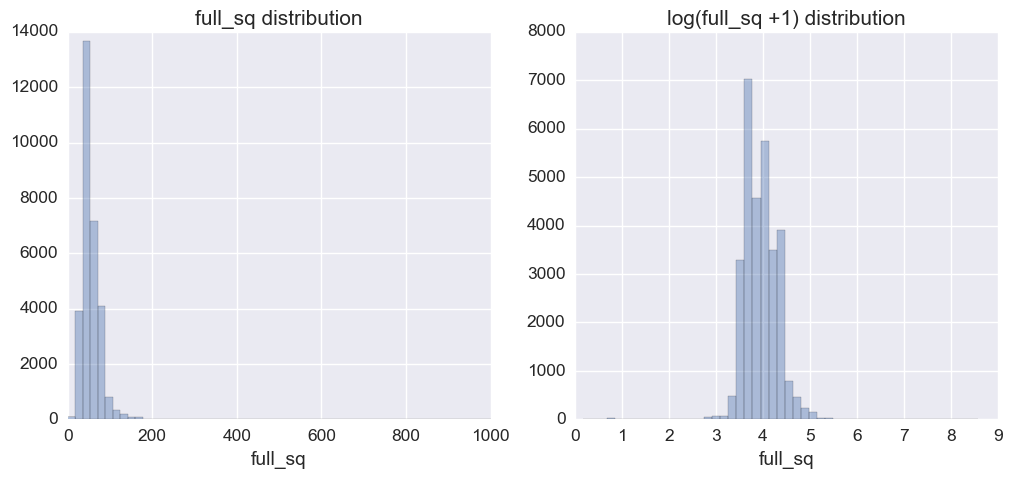

In [171]:
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
F=sns.distplot(train_macro['full_sq'], kde=False, ax=ax[0], bins=300)
F.set(xlim=(0,1000),title='full_sq distribution')
F1=sns.distplot(np.log1p(train_macro['full_sq']), kde=False,ax=ax[1])
F1.set(title='log(full_sq +1) distribution');

In [172]:
X_train=train_test_macro.copy()
X_train['price_doc']=train_test_macro1['price_doc']
X_train=X_train[:train_macro.shape[0]]
X_train.drop(['timestamp'], axis=1, inplace=True)
X_train.drop(X_train.columns[X_train.dtypes=='object'], axis=1, inplace=True)

features=[f for f in X_train.columns if X_train[f].nunique()>5]
df_corr = X_train.corr(method='pearson', min_periods=100)
df_corr = np.abs(df_corr)

X_train_new=X_train.copy()
for f in features:
    X_train_new[f]=np.log1p(X_train[f])
df_corr_new = X_train_new.corr(method='pearson', min_periods=100)
df_corr_new = np.abs(df_corr_new)

feature_logtransform=[]
for f in features:
    if f =='price_doc':
        continue
    
    if np.abs(X_train[f].skew())>1 and np.abs(X_train[f].skew()) > np.abs(np.log1p(X_train[f]).skew()):
        if (df_corr_new['price_doc'][f]-df_corr['price_doc'][f]) > 0.01:
            print '###################'
            print f
            print X_train[f].nunique()
            print 'Skew values before/after log transformation: {} | {}' .format(X_train[f].skew(),np.log1p(X_train[f]).skew())
            print 'Correlation coeff with price before/after log transformation: {} | {}'.\
            format(df_corr['price_doc'][f],df_corr_new['price_doc'][f])
            feature_logtransform.append(f)

###################
additional_education_raion
12
Skew values before/after log transformation: 2.52866013268 | 0.0747680706125
Correlation coeff with price before/after log transformation: 0.0610499998997 | 0.0958318971168
###################
big_church_count_1000
24
Skew values before/after log transformation: 5.17682990343 | 2.404515049
Correlation coeff with price before/after log transformation: 0.0585971437167 | 0.117268984349
###################
big_church_count_2000
63
Skew values before/after log transformation: 5.54750269758 | 1.7084566933
Correlation coeff with price before/after log transformation: 0.0506012434412 | 0.155717096473
###################
big_church_count_3000
101
Skew values before/after log transformation: 4.65760940223 | 1.01603493651
Correlation coeff with price before/after log transformation: 0.087180144377 | 0.184585705672
###################
big_church_count_500
11
Skew values before/after log transformation: 5.7267331552 | 3.83872751474
Correlation coeff

In [173]:
for f in feature_logtransform:
    train_test_macro[f]=np.log1p(train_test_macro[f])

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Categorical variables treatment </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> I encode categorical values by converting each unique value in a feature to a number

        
 </span></div>

In [174]:
from sklearn.preprocessing import LabelEncoder
for f in train_test_macro.columns[train_test_macro.dtypes =='object']:
    if f == 'ecology':
        continue
    Label_Encoder=LabelEncoder()
    train_test_macro[f]=Label_Encoder.fit_transform(train_test_macro[f].values) 
train_test_macro['ecology'].replace({'no data': 0, 'poor': 1,'satisfactory': 2, 'good': 3, 'excellent': 4}, inplace=True)

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Correlation heatmap of output variable 
 </span></div>

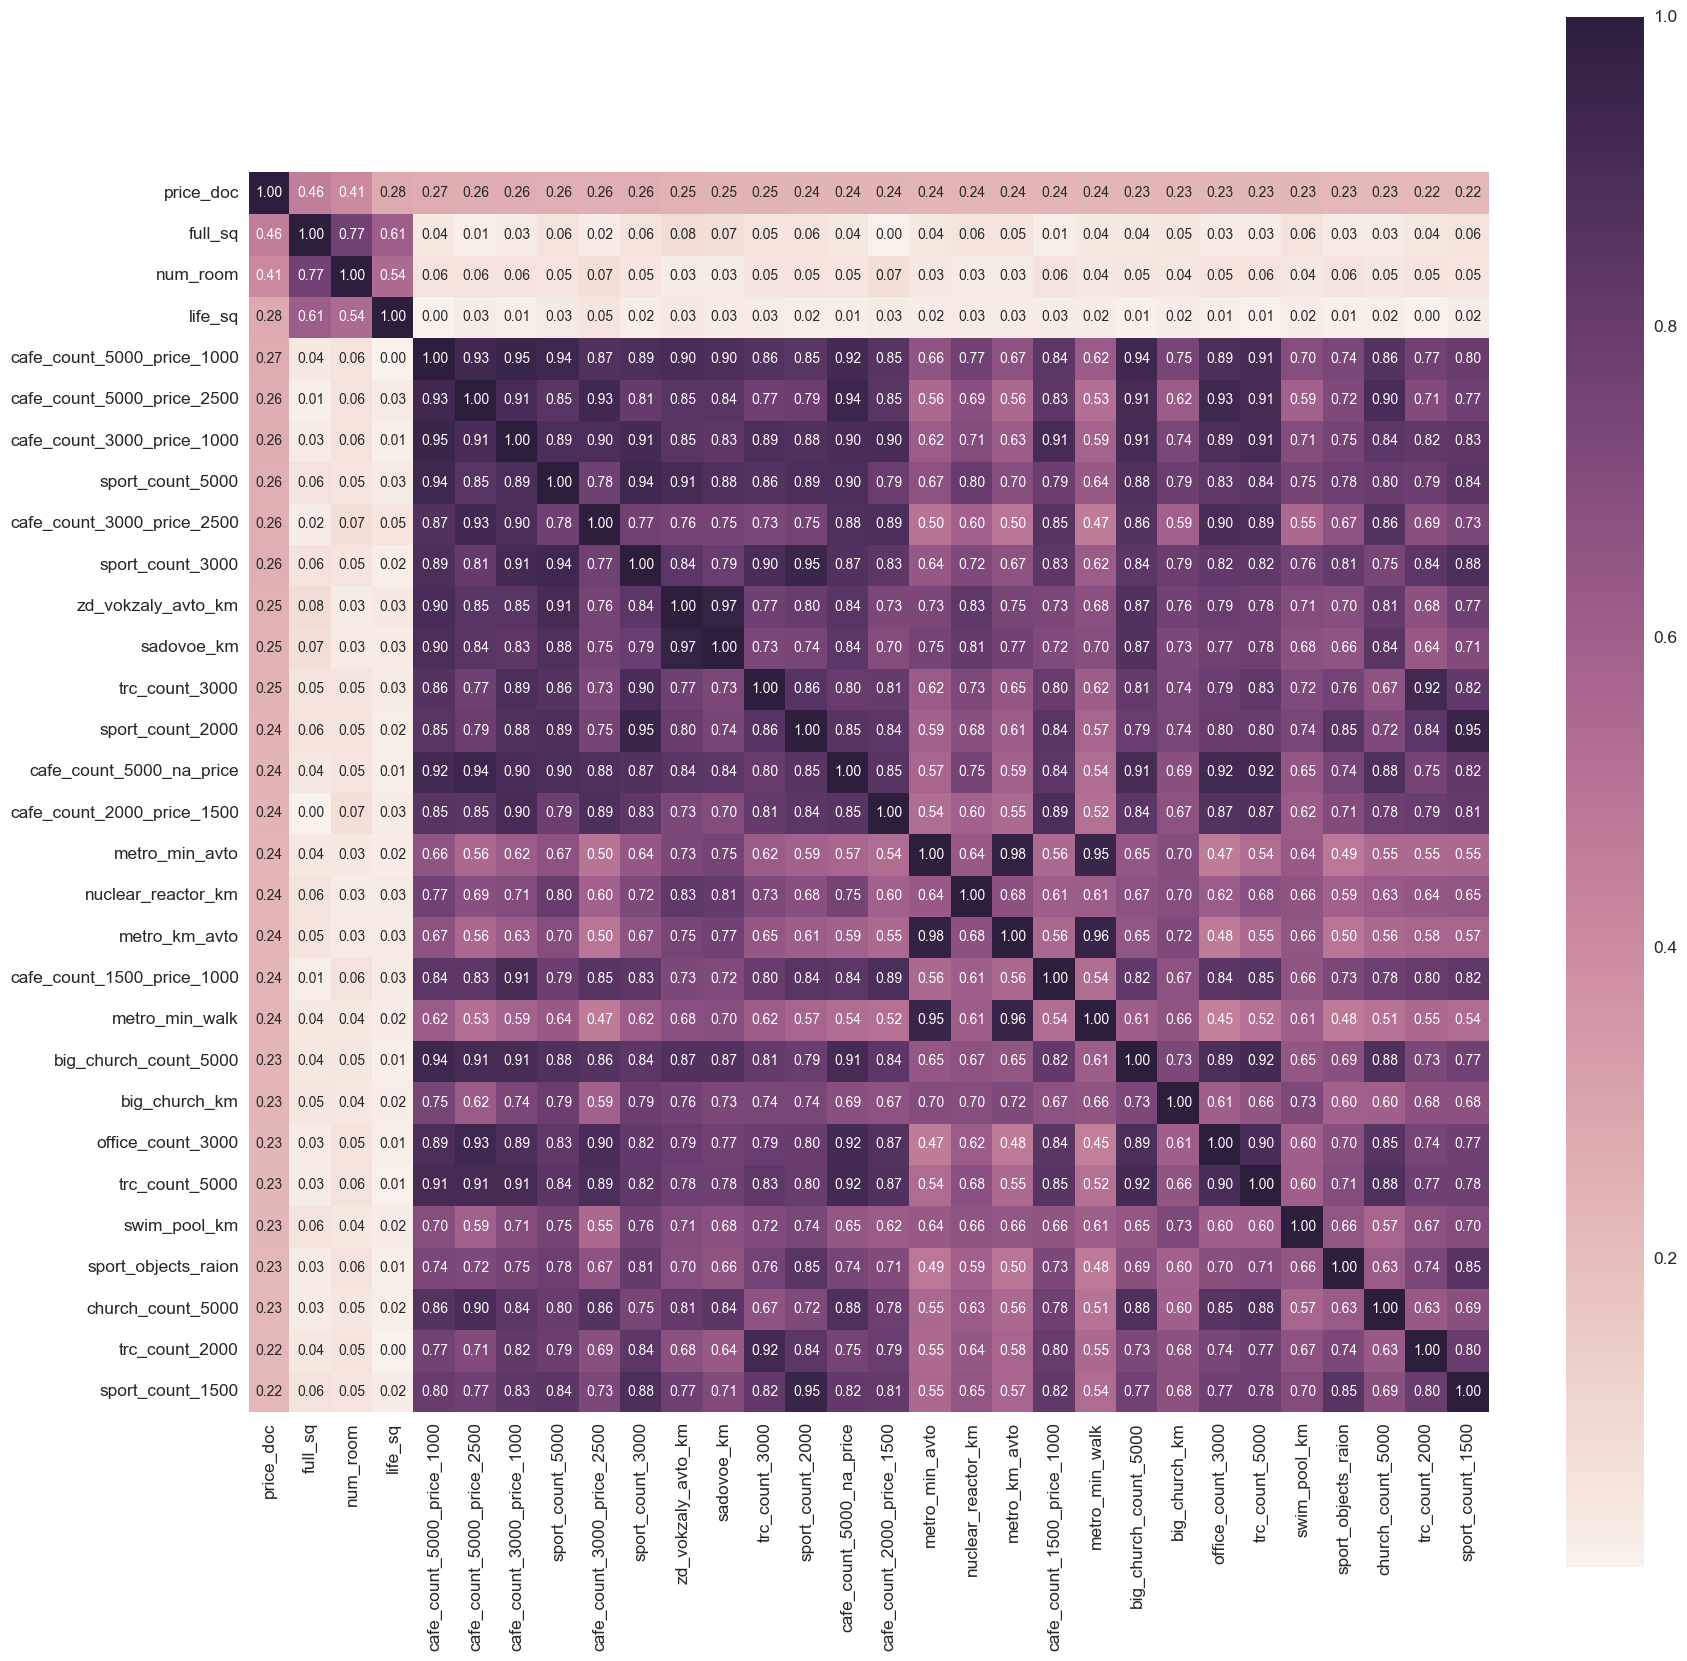

In [175]:
X_train=train_test_macro.copy()
X_train['price_doc']=train_test_macro1['price_doc']
X_train=X_train[:train_macro.shape[0]]
f, ax = plt.subplots(figsize=(20, 20))
k = 30 #number of variables for heatmap
df_corr = X_train.corr(method='pearson', min_periods=100)
df_corr = np.abs(df_corr)
cols = df_corr.nlargest(k, 'price_doc')['price_doc'].index
cm=X_train[cols].corr(method='pearson', min_periods=100)
cm = np.abs(cm)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, \
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<div style="text-align:left"><span style="color:blue; font-family:Times New Roman; font-size:1.8em;">  
Outlier treatment  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> Full_sq (total area in square meters),  num_room (number of living rooms) and life_sq (living area in square meters) are the top three features that show high correlation with price_doc. However, from the figures below, there are some outliers that appear far away from an overall linear pattern. These outliers may bias or influence the model performance.  I assign these outliers as ‘NULL’ values.
        
 </span></div>

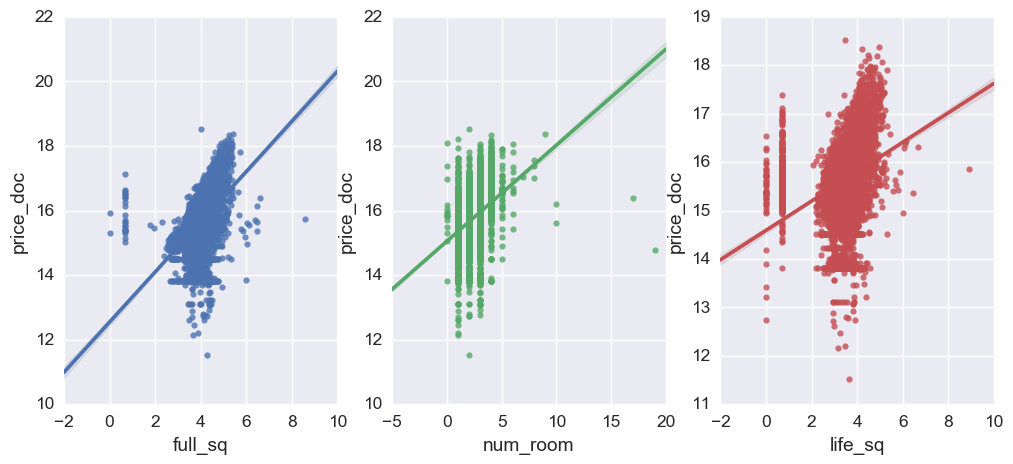

In [176]:
f, ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
F1=sns.regplot(x=X_train['full_sq'],y=X_train['price_doc'], ax=ax[0])
F2=sns.regplot(x=X_train['num_room'],y=X_train['price_doc'], ax=ax[1])
F2=sns.regplot(x=X_train['life_sq'],y=X_train['price_doc'], ax=ax[2])

In [177]:
train_test_macro.loc[train_test_macro['full_sq'] >8, 'full_sq'] = np.nan
train_test_macro.loc[train_test_macro['full_sq'] <=1, 'full_sq'] = np.nan
train_test_macro.loc[train_test_macro['num_room'] >= 10, 'num_room'] = np.nan
train_test_macro.loc[train_test_macro['life_sq'] >8, 'life_sq'] = np.nan
train_test_macro.loc[train_test_macro['life_sq'] <=1, 'life_sq'] = np.nan

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> After data preprocessing, the data is well prepared and saved in a CSV file for XGBoost modeling.  
        
 </span></div>

In [179]:
train_test_macro.drop(["timestamp"],axis=1, inplace=True)
train_test_macro.shape

(38132, 302)

In [180]:
train_test_macro.to_csv('train_test_macro_final_version.csv', index=False)
train_test_macro1.to_csv('train_test_macro1_final_version.csv', index=False)